<a href="https://colab.research.google.com/github/akshaya-nagarajan/MachineLearning/blob/master/MLNodeRankMulticlassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/MLSpring2020/"
base_dir = root_dir + 'the_expendables_AirQuality_Traffic'
myDrive = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, mean_squared_error, f1_score
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from dateutil.parser import parse 
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading Liar Liar Dataset

In [0]:
liarFilepath = base_dir + '/Alternus_vera/liar_dataset/Liardataset.csv'

In [0]:
df_liar = pd.read_csv(liarFilepath, encoding= 'unicode_escape')

In [5]:
print('Liar-Liar - Fake and Truth Combined', df_liar.shape)

Liar-Liar - Fake and Truth Combined (12791, 14)


## Drop off unwanted columns

In [0]:
df_liar = df_liar.drop(columns=['json', 'subject', 'speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'])

In [7]:
df_liar.head(1)

,class,statement,speaker
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac


## Code for getting the news source of the article as Politifact.com returns a node rank of 1.0 all the time. Therefore getting the direct source of the news article by scaping the URLs from Google search.

In [0]:
import urllib.request as urllib2
from lxml import html
import requests

def get_page_tree(url):
    page = requests.get(url=url, verify=False)
    return html.fromstring(page.text)

def get_title(url):
    tree = get_page_tree(url)
    return tree.xpath('//title//text()')[0].strip().split(' -')[0]

def find_other_news_sources(url,title):
    forwarding_identifier = '/url?q='
    if not title:
        title = get_title(url=url)
    google_news_search_url = 'http://www.google.com/search?q=' + urllib2.quote(title) + '&tbm=nws' + url
    google_news_search_tree = get_page_tree(url=google_news_search_url)
    other_news_sources_links = [a_link.replace(forwarding_identifier, '').split('&')[0] for a_link in google_news_search_tree.xpath('//a//@href') if forwarding_identifier in a_link]
    return other_news_sources_links

In [9]:
# df_liar['link'] = df_liar.head(1).apply(lambda x: find_other_news_sources("www.politifact.com", x['statement']), axis=1)
link = df_liar.head(1).apply(lambda x: find_other_news_sources("www.politifact.com", x['statement']), axis=1)
print(link[0])

['https://www.politifact.com/factchecks/2010/oct/20/dwayne-bohac/texas-rep-dwayne-bohac-says-annies-list-supports-t/', 'https://www.politifact.com/texas/article/2011/feb/01/pro-life-pro-choice-pro-truth/', 'https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/', 'https://www.washingtonpost.com/politics/amid-a-shifting-legal-landscape-on-abortion-both-parties-seek-political-advantage/2019/02/11/8e289cb4-2be1-11e9-b011-d8500644dc98_story.html', 'https://www.nytimes.com/2019/11/25/us/politics/abortion-laws-2020-democrats.html', 'https://www.npr.org/2019/04/30/718546468/opponents-fight-efforts-to-protect-late-term-abortion-rights', 'https://en.wikipedia.org/wiki/Abortion_law', 'https://github.com/UCSB-dataScience-ProjectGroup/fakeNewsPrediction/blob/master/factCheck.csv', 'https://abcnews.go.com/Politics/issue-late-term-abortion-trump-seeks-corner-democrats/story%3Fid%3D61481423', 'https://www.statesman.com/news/20200227/fact-check-do-democrats-support-aborti

In [0]:
# for key, value in df_liar.iterrows():
#   if key >= 2433 and key <= 2434:    
#     value.link = find_other_news_sources("www.politifact.com", value.statement)
#     df_liar['link'][key] = value.link

In [0]:
# df_liar['link'][2433]

## Saving the Sources of 3000 scraped news articles URLs in CSV file.

In [0]:
# with open(base_dir + '/Alternus_vera/liarwithsource.csv', 'a') as f:
#   df_liar.to_csv(f)

In [0]:
liarWithSourceFilepath = base_dir + '/Alternus_vera/liarwithsource.csv'

In [0]:
df = pd.read_csv(liarWithSourceFilepath, encoding= 'unicode_escape')

In [15]:
df.shape

(3002, 6)

In [16]:
df.head(1)

,Unnamed: 0,class,statement,speaker,fakeness,link
0,0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,1,['https://www.politifact.com/factchecks/2010/o...


## Dropping off unwanted columns

In [0]:
df = df.drop(columns=['Unnamed: 0', 'fakeness'])

In [18]:
df.head(10)

,class,statement,speaker,link
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...
1,half-true,When did the decline of coal start? It started...,scott-surovell,['https://www.politifact.com/factchecks/2015/f...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,['https://www.politifact.com/factchecks/2008/f...
3,FALSE,Health care reform legislation is likely to ma...,blog-posting,['https://www.politifact.com/truth-o-meter/sta...
4,half-true,The economic turnaround started at the end of ...,charlie-crist,['https://www.politifact.com/factchecks/2014/m...
5,TRUE,The Chicago Bears have had more starting quart...,robin-vos,['https://www.politifact.com/factchecks/2016/j...
6,barely-true,Jim Dunnam has not lived in the district he re...,republican-party-texas,['https://www.politifact.com/factchecks/2010/s...
7,half-true,I'm the only person on this stage who has work...,barack-obama,['https://www.politifact.com/factchecks/2007/o...
8,half-true,"However, it took $19.5 million in Oregon Lotte...",oregon-lottery,['https://www.politifact.com/factchecks/2012/m...
9,mostly-true,Says GOP primary opponents Glenn Grothman and ...,duey-stroebel,['https://www.politifact.com/factchecks/2014/a...


## Cleaning the links from google search which has quotes and brackets.

In [0]:
def processLinks(link):
  allUrls = link.split(",")
  sourceList = []
  for i in range(len(allUrls)):
    sourceList.append(allUrls[i].replace('\'', '').replace('[', '').replace('\'', '').replace(' ', ''))
  return sourceList

In [0]:
df['source'] = df.apply(lambda x: processLinks(x['link']), axis=1)

## Cleaned links are stored in the source column

In [21]:
df['source']

0       [https://www.politifact.com/factchecks/2010/oc...
1       [https://www.politifact.com/factchecks/2015/fe...
2       [https://www.politifact.com/factchecks/2008/fe...
3       [https://www.politifact.com/truth-o-meter/stat...
4       [https://www.politifact.com/factchecks/2014/ma...
                              ...                        
2997    [https://www.politifact.com/factchecks/2008/fe...
2998    [https://www.politifact.com/factchecks/2012/no...
2999    [https://www.politifact.com/factchecks/2010/ju...
3000    [https://www.politifact.com/factchecks/2011/se...
3001    [https://www.thebalance.com/job-creation-by-pr...
Name: source, Length: 3002, dtype: object

In [22]:
df.head(1)

,class,statement,speaker,link,source
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...,[https://www.politifact.com/factchecks/2010/oc...


## Considering the link (other than politifact domain) from a list of scraped Links from google search.

In [0]:
def considerSingleSource(links):
  link = ""
  for i in range(len(links)):
    if "politifact" not in links[i]:
      return links[i]
  return links[0]

In [0]:
df['singlesource']= df.apply(lambda x: considerSingleSource(x['source']), axis=1)

## Link for which pagerank/node rank is to be calculated is in singlesource column


In [25]:
df['singlesource']

0       https://www.theatlantic.com/politics/archive/2...
1       https://www.theatlantic.com/politics/archive/2...
2       https://www.outsidethebeltway.com/obama_ties_c...
3       https://www.cnbc.com/2018/03/27/work-health-in...
4       https://www.nbcnews.com/politics/politics-news...
                              ...                        
2997    https://www.investors.com/politics/editorials/...
2998      https://americansfortaxfairness.org/type/media/
2999    https://www.georgiastandards.org/Georgia-Stand...
3000    https://www.aei.org/economics/aging/how-genero...
3001    https://www.thebalance.com/job-creation-by-pre...
Name: singlesource, Length: 3002, dtype: object

In [26]:
df.head()

,class,statement,speaker,link,source,singlesource
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...,[https://www.politifact.com/factchecks/2010/oc...,https://www.theatlantic.com/politics/archive/2...
1,half-true,When did the decline of coal start? It started...,scott-surovell,['https://www.politifact.com/factchecks/2015/f...,[https://www.politifact.com/factchecks/2015/fe...,https://www.theatlantic.com/politics/archive/2...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,['https://www.politifact.com/factchecks/2008/f...,[https://www.politifact.com/factchecks/2008/fe...,https://www.outsidethebeltway.com/obama_ties_c...
3,FALSE,Health care reform legislation is likely to ma...,blog-posting,['https://www.politifact.com/truth-o-meter/sta...,[https://www.politifact.com/truth-o-meter/stat...,https://www.cnbc.com/2018/03/27/work-health-in...
4,half-true,The economic turnaround started at the end of ...,charlie-crist,['https://www.politifact.com/factchecks/2014/m...,[https://www.politifact.com/factchecks/2014/ma...,https://www.nbcnews.com/politics/politics-news...


In [27]:
pip install git+https://github.com/mitsuhiko/flask-oauth

  Cloning https://github.com/mitsuhiko/flask-oauth to /tmp/pip-req-build-qrvn1rbr
  Running command git clone -q https://github.com/mitsuhiko/flask-oauth /tmp/pip-req-build-qrvn1rbr
  Running command git submodule update --init --recursive -q
  Created wheel for Flask-OAuth: filename=Flask_OAuth-0.13-cp36-none-any.whl size=7300 sha256=ad5cff13d20edc785f79253bf204407e4966161d22a473dd70478ef8a00bd0d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycboshzp/wheels/c4/bc/23/62f2b06186a0307601258efa25becf1cb4b114a73c17eafecc
Successfully built Flask-OAuth


## Code to web scrape the URLs in singlesource column - Outlinks from the page, Calculating the Page rank, number of nodes and number of edges, finally constructing a graph for each node.

In [0]:
import subprocess
from urllib.parse import urlparse
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
from urllib.parse import urlencode
import socket
from multiprocessing import Queue
import threading
import getopt
import sys
import os
import networkx as nx
from bs4 import BeautifulSoup
import matplotlib

import matplotlib.pyplot as plt

import threading, queue
import re
q = queue.Queue()
max_threads=50
next_url=queue.Queue()
crawled_urls=[]

def check_link(url):
    domain = '.'.join(urlparse(url).netloc.split('.')[-2:])
    filetype = urlparse(url).path.split('/')[-1:][0].split('.')[-1:][0]
    if  (domain == 'politifact.com' and filetype != 'pdf'):
      return True
    else:
      return False

def get_host(url):
  try:
    return socket.gethostbyname(urlparse(url).netloc)
  except:
      pass
  return None

def get_links_from_page(url):
    urllist = []
    try:
      res=urllib2.urlopen(url)
      htmlpage=res.read()
    except:
      return urllist

    try:
      page=BeautifulSoup(htmlpage)
    except:
      return urllist

    #refs=page.findAll("a")
    pattern = re.compile(r"https://www.*.com/*")
    refs = page.findAll("a", href=pattern)[25:35]
    for a in refs:
      try:
        link = a['href']
        if link[:4] == 'http':
          urllist.append(link)
      except:
        pass

    return urllist

def find_links(url_tuple,graph):
    '''Crawls to a given depth using a tuple structure to tag urls with their depth'''
    global crawled_urls, next_url, max_depth
    url = url_tuple[0]
    depth = url_tuple[1]
    if (depth < 2) :
      links = get_links_from_page(url)
      for link in links:
        '''These two lines create the graph'''
        graph.add_node(link)
        graph.add_edge(url,link)
        '''If the link has not been crawled yet, add it in the queue with additional depth'''
        if link not in crawled_urls:
          next_url.put((link, depth+1))
          crawled_urls.append(link)
    return 

class crawler_thread(threading.Thread):
    def __init__(self,queue,graph):
      threading.Thread.__init__(self)
      self.to_be_crawled=queue
      self.graph=graph
      while self.to_be_crawled.empty() is False:
        find_links(self.to_be_crawled.get(), self.graph)

def draw_graph(graph, graph_file_name):
	'''Function to draw the graph and save the files'''
	nx.draw(graph,with_labels=False)
	nx.write_dot(graph,os.cwd()+graph_file_name+'.dot')
	plt.savefig(os.cwd()+graph_file_name+'.png')


In [0]:
# root_url = 'https://www.politico.com/story/2010/02/underwear-bomber-talking-again-032413' # --------- 0.005 , edges  -------- 6600, nodes --- 1900
# root_url='https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/'
# root_url = 'https://taxfoundation.org/summary-latest-federal-income-tax-data-2018-update/' # ------- 0.0042217689303551105 , edges ---- 160000, nodes ---2300

def calculatePageRank(url):
  print(str(url))
  root_url = url
  parser_flag = 'beautifulsoup'
  max_depth=2

  next_url.put((root_url,0))
  crawled_urls.append(root_url)
  ip_list=[]
  g=nx.Graph()
  g.add_node(root_url)
  thread_list=[]

  for i in range(max_threads): #changed
    t=crawler_thread(next_url,g)
    t.daemon=True
    t.start()
    thread_list.append(t)

  for t in thread_list:
    t.join()

  # for url in crawled_urls:
  #   ip_list.append(socket.gethostbyname(urlparse(url).netloc))
  #   ip_set=set(ip_list)
  #   ip_list = [*ip_set, ]

  # print("Unique Host: %s " % len(ip_list))
  pagerank = nx.pagerank_numpy(g, alpha=0.85, personalization=None,  weight='weight', dangling=None)
  edgeNumber = g.number_of_edges()
  nodeNumber = g.number_of_nodes()
  nodesize=[g.degree(n)*10 for n in g]
  pos=nx.spring_layout(g,iterations=20)

  nx.draw(g,with_labels=False)
  nx.draw_networkx_nodes(g,pos,node_size=nodesize,node_color='r')
  nx.draw_networkx_edges(g,pos)
  plt.figure(figsize=(5,5))
  plt.show()
  # return np.array(len(ip_list), pagerank.get(url), edgeNumber, nodeNumber)
  return pd.Series([pagerank.get(url), edgeNumber, nodeNumber], index=['pagerank','edges', 'nodes'])

## Graph Structure - Node represent the URLs and edges are the outlinks. Red nodes vary in size based on the degree of importance of the nodes. Each Article has many outlinks. For Simplicity, considering only 5 to 10 nodes in each article.

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


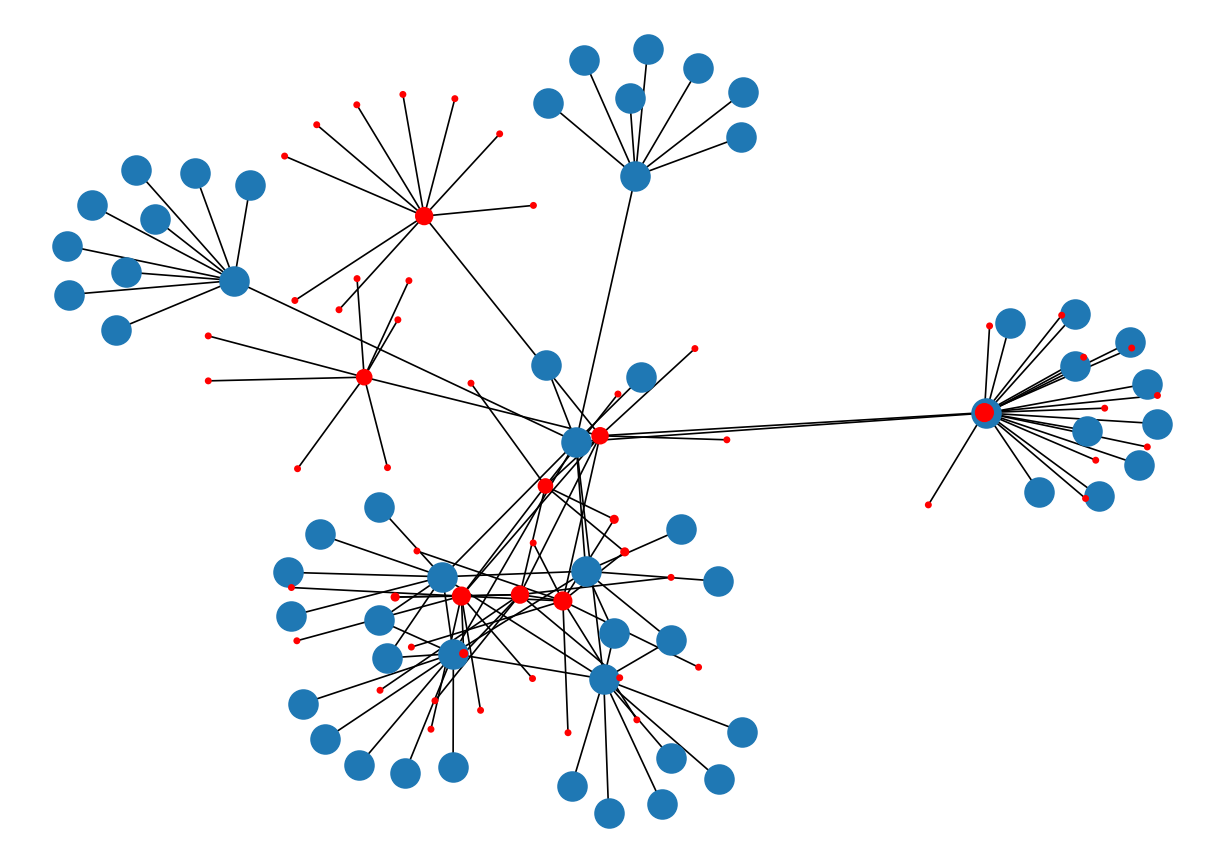

<Figure size 600x600 with 0 Axes>

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


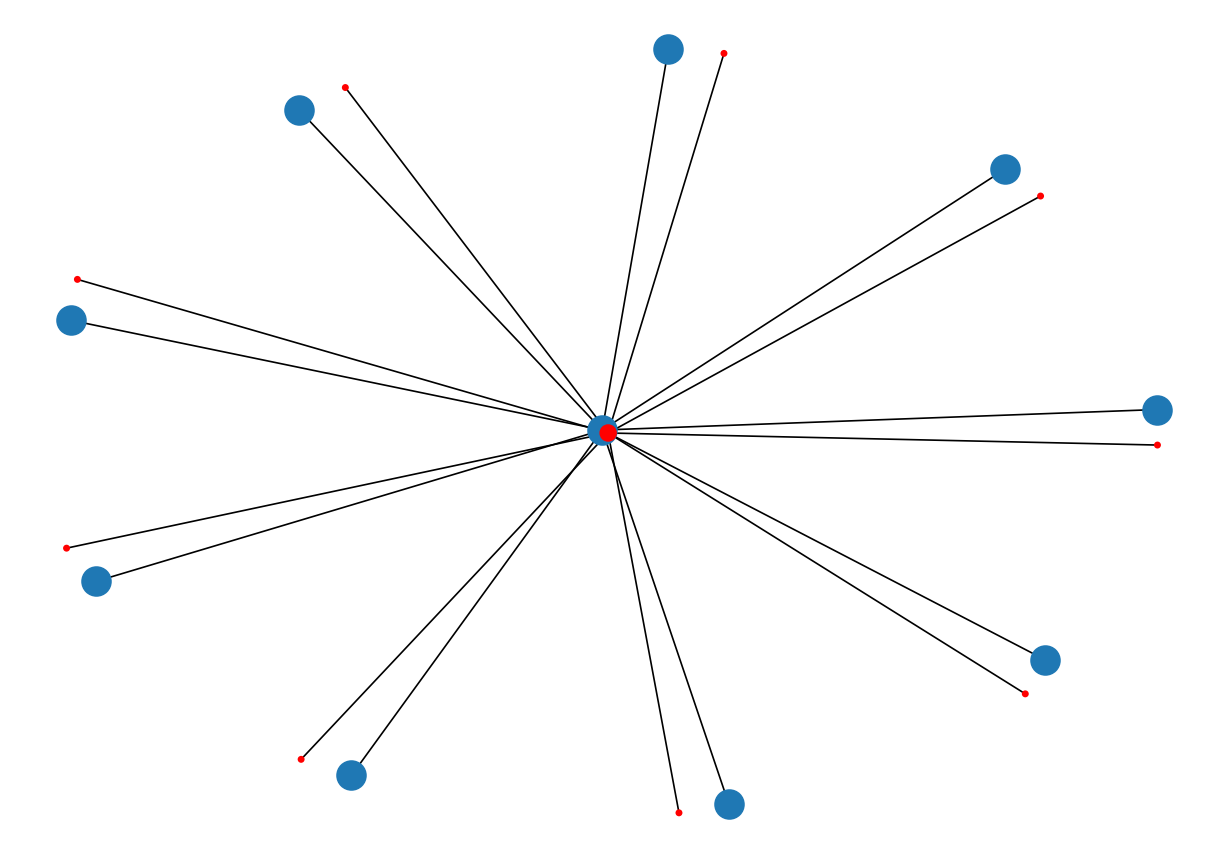

<Figure size 600x600 with 0 Axes>

In [30]:
df[['pagerank','edges', 'nodes']] = df.head(1).apply(lambda x: calculatePageRank(x['singlesource']), axis=1)

## Sample node rank/ number of edges and nodes calculation. This process consumes time. Therefore calculating them in batches and stored in CSV file below.

https://www.theatlantic.com/politics/archive/2019/06/2020-democrats-abortion/590701/


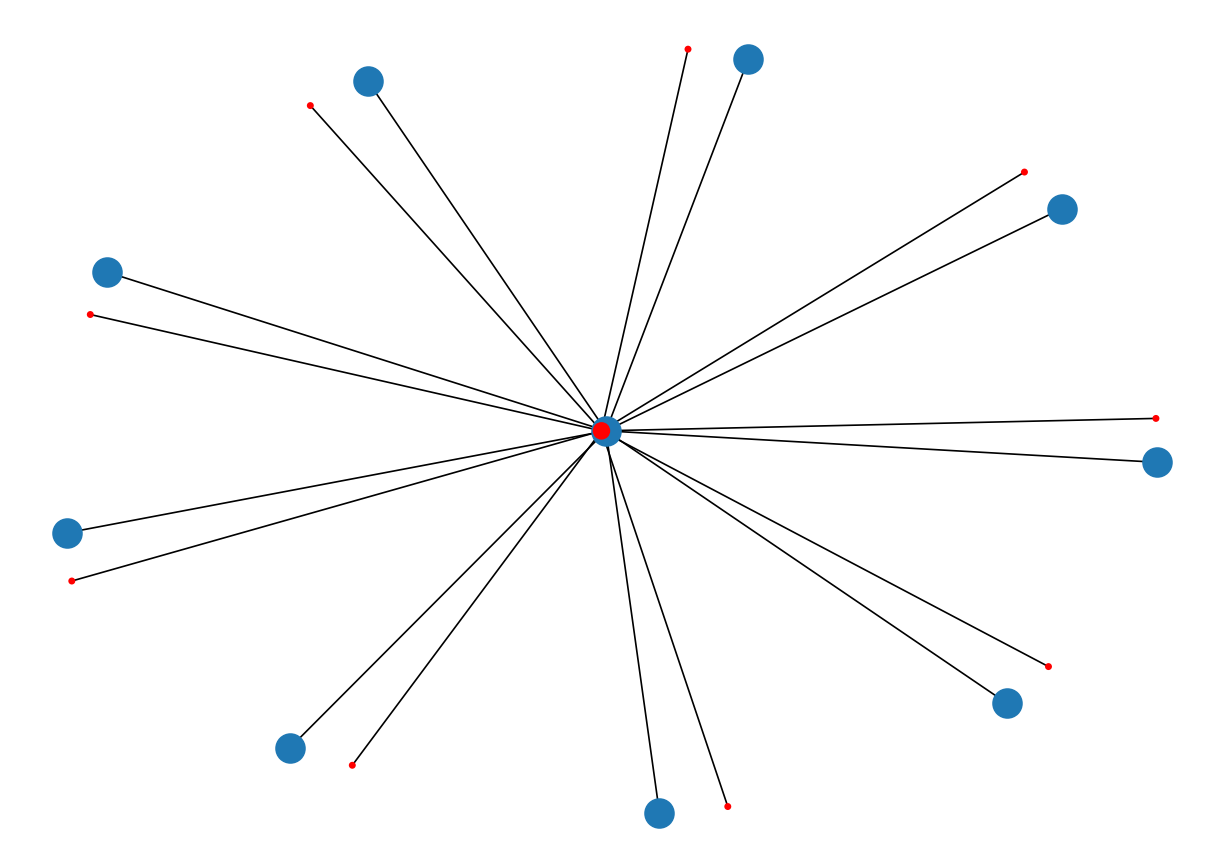

<Figure size 600x600 with 0 Axes>

0.4675675675675677
9.0
10.0
https://www.theatlantic.com/politics/archive/2013/10/coal-countrys-decline-has-a-long-history/453144/


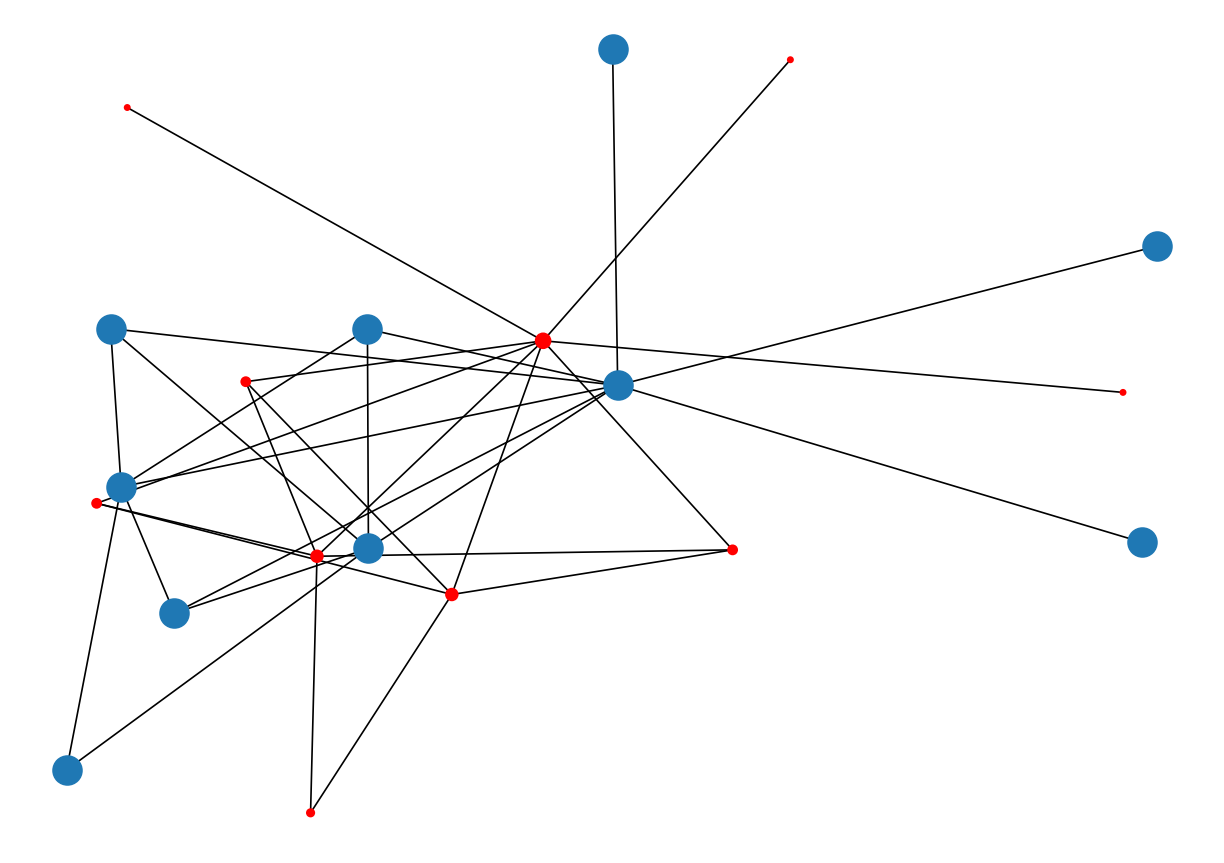

<Figure size 600x600 with 0 Axes>

0.24706192565772622
16.0
10.0
https://www.outsidethebeltway.com/obama_ties_clinton_policies_to_bushs/


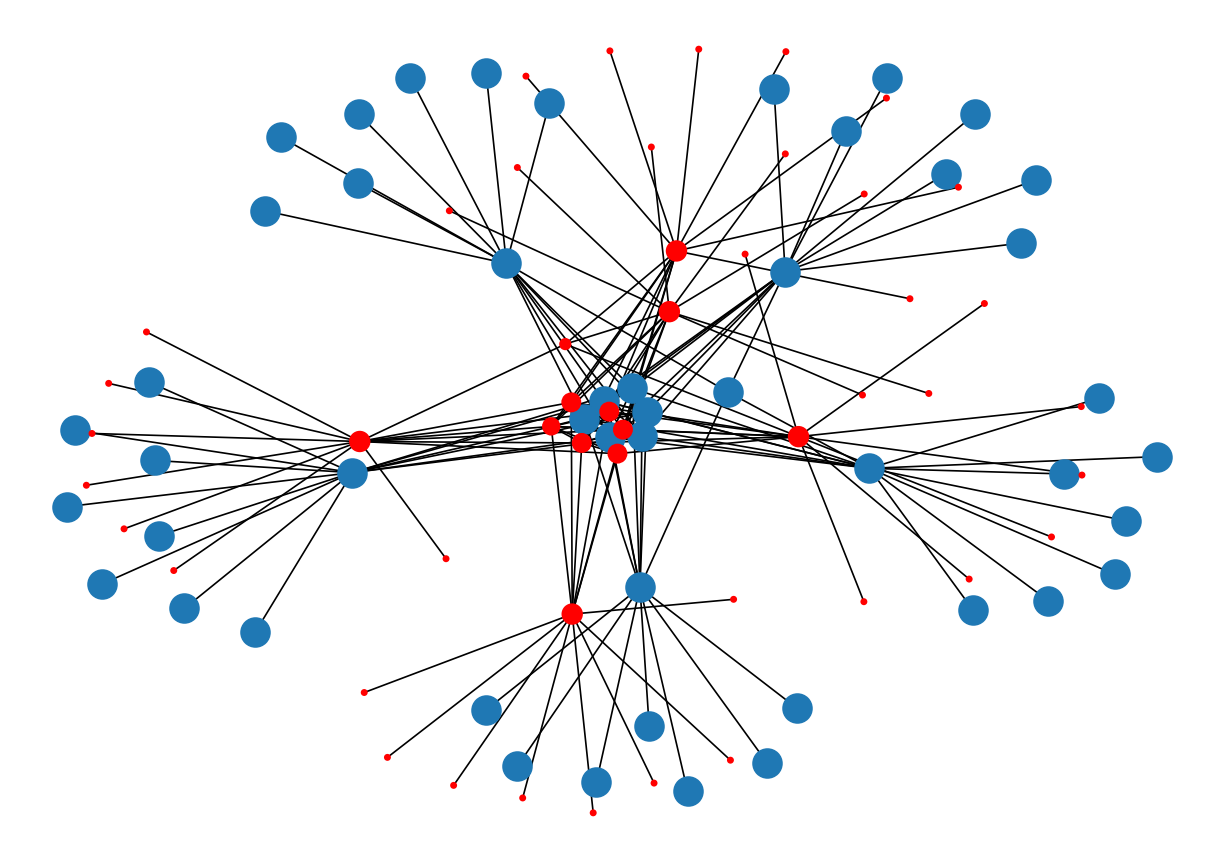

<Figure size 600x600 with 0 Axes>

0.046558446774521665
90.0
48.0


In [31]:
for key, value in df.iterrows():
  if key >= 0 and key <= 2:    
    value.pagerank, value.edges, value.nodes = calculatePageRank(value.singlesource)
    print(value.pagerank)
    print(value.edges)
    print(value.nodes)

## Loading the previously computed node rank, edges and nodes in dataframe for Liar-Liar dataset.

In [0]:
noderank_liar = base_dir + '/Alternus_vera/noderank.csv'

In [0]:
df_noderank_liar = pd.read_csv(noderank_liar, lineterminator='\n')

In [34]:
df_noderank_liar.head(5)

,Unnamed: 0,class,statement,speaker,link,source,singlesource,pagerank,edges,nodes\r
0,0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,['https://www.politifact.com/factchecks/2010/o...,['https://www.politifact.com/factchecks/2010/o...,https://www.theatlantic.com/politics/archive/2...,0.486486,2.0,3.0
1,1,half-true,When did the decline of coal start? It started...,scott-surovell,['https://www.politifact.com/factchecks/2015/f...,['https://www.politifact.com/factchecks/2015/f...,https://www.theatlantic.com/politics/archive/2...,0.245492,4.0,5.0
2,2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,['https://www.politifact.com/factchecks/2008/f...,['https://www.politifact.com/factchecks/2008/f...,https://www.outsidethebeltway.com/obama_ties_c...,0.162838,6.0,6.0
3,3,FALSE,Health care reform legislation is likely to ma...,blog-posting,['https://www.politifact.com/truth-o-meter/sta...,['https://www.politifact.com/truth-o-meter/sta...,https://www.cnbc.com/2018/03/27/work-health-in...,0.259740,5.0,3.0
4,4,half-true,The economic turnaround started at the end of ...,charlie-crist,['https://www.politifact.com/factchecks/2014/m...,['https://www.politifact.com/factchecks/2014/m...,https://www.nbcnews.com/politics/politics-news...,0.259740,5.0,3.0


## Dropping off unwanted columns

In [0]:
df_noderank_liar = df_noderank_liar.drop(columns=['Unnamed: 0', 'link', 'source'])

## Renaming the columns


In [0]:
df_noderank_liar=df_noderank_liar.rename(columns={'class':'labels', 'nodes\r': 'nodes'})

In [37]:
df_noderank_liar.head(5)

,labels,statement,speaker,singlesource,pagerank,edges,nodes
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,0.486486,2.0,3.0
1,half-true,When did the decline of coal start? It started...,scott-surovell,https://www.theatlantic.com/politics/archive/2...,0.245492,4.0,5.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,https://www.outsidethebeltway.com/obama_ties_c...,0.162838,6.0,6.0
3,FALSE,Health care reform legislation is likely to ma...,blog-posting,https://www.cnbc.com/2018/03/27/work-health-in...,0.259740,5.0,3.0
4,half-true,The economic turnaround started at the end of ...,charlie-crist,https://www.nbcnews.com/politics/politics-news...,0.259740,5.0,3.0


In [0]:
df_noderank_liar = df_noderank_liar[:-1]

# Applying Classification model only on Liar-Liar - Considering only pagerank, edges, nodes

In [0]:
le = preprocessing.LabelEncoder()
le.fit(df_noderank_liar.labels)
df_noderank_liar['labels_cat'] = le.fit_transform(df_noderank_liar['labels'])

In [40]:
list(le.classes_)

['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire']

In [41]:
le.transform(['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire'])

array([0, 1, 2, 3, 4, 5])

In [42]:
labels = list(le.inverse_transform([0, 1, 2, 3, 4, 5]))
labels

['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire']

In [43]:
df_noderank_liar.head()

,labels,statement,speaker,singlesource,pagerank,edges,nodes,labels_cat
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,0.486486,2.0,3.0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,https://www.theatlantic.com/politics/archive/2...,0.245492,4.0,5.0,3
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,https://www.outsidethebeltway.com/obama_ties_c...,0.162838,6.0,6.0,4
3,FALSE,Health care reform legislation is likely to ma...,blog-posting,https://www.cnbc.com/2018/03/27/work-health-in...,0.259740,5.0,3.0,0
4,half-true,The economic turnaround started at the end of ...,charlie-crist,https://www.nbcnews.com/politics/politics-news...,0.259740,5.0,3.0,3


In [44]:
unique_val = df_noderank_liar.speaker.unique()
len(unique_val)

1270

In [45]:
df_noderank_liar.speaker.dtype

dtype('O')

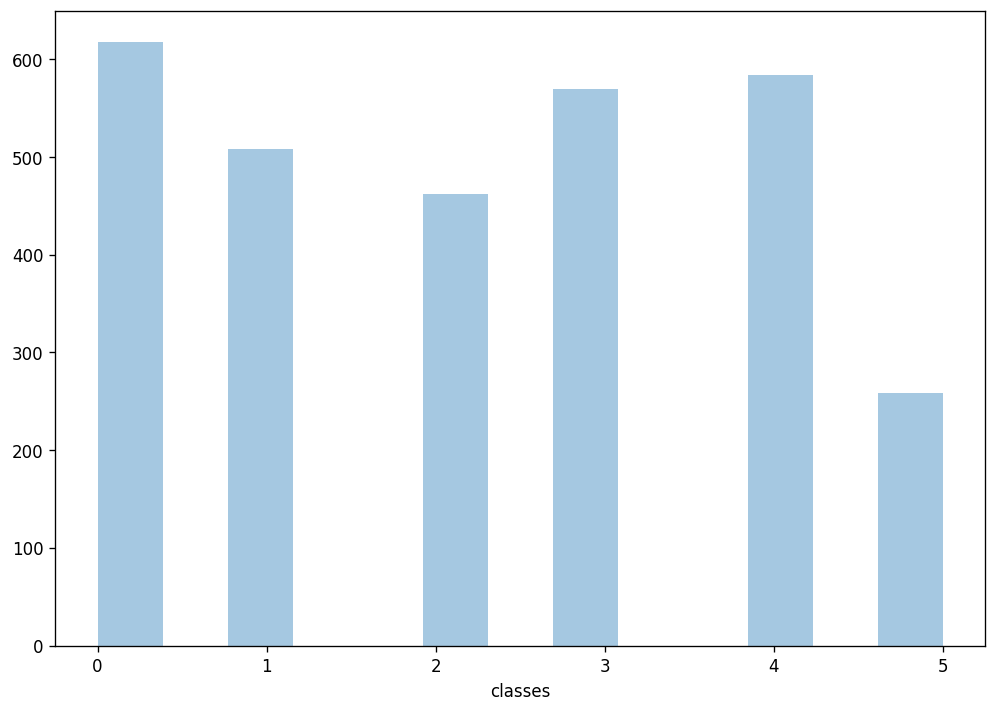

In [46]:
sns.distplot(pd.Series(df_noderank_liar.labels_cat, name="classes"), kde=False)

In [0]:
df_noderank_liar['pagerank'] = df_noderank_liar['pagerank'].apply(lambda x: x*10)

In [48]:
X = df_noderank_liar[['pagerank', 'edges', 'nodes']]
#X = df_noderank_liar[['pagerank']]
y = df_noderank_liar.labels_cat
#y = df_noderank_liar.bin_labels

#Print the shape of X and Y
print(X.shape)
print(y.shape)

(3001, 3)
(3001,)


In [0]:
# scaler = MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [0]:
#X = preprocessing.scale(X)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [53]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400, 3) (2400,)
(601, 3) (601,)


### Random Forest Classifier on Liar-Liar

In [54]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf_predictions = rf_classifier.predict(X_test)  

In [0]:
rf_predictions_labels = [np.argmax(p) for p in rf_predictions]

In [57]:
class_report = classification_report(y_test, rf_predictions_labels, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
accuracy = accuracy_score(y_test, rf_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, rf_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, rf_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, rf_predictions_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
val = {'Model': ['RandomForest (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf.head()

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731


### Decision Tree on Liar Liar Dataset

In [0]:
clf = tree.DecisionTreeClassifier() 
clf = clf.fit(X_train, y_train)

In [0]:
tree_pred = clf.predict(X_test)

In [0]:
tree_pred_labels = [np.argmax(p) for p in tree_pred]

In [63]:
class_report = classification_report(y_test, tree_pred_labels, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
accuracy = accuracy_score(y_test, tree_pred_labels)* 100.0
precision = metrics.precision_score(y_test, tree_pred_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, tree_pred_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, tree_pred_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
val = {'Model': ['Decision Tree (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf1 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf1], ignore_index=True, sort=False)
outputDf.head()

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731


### XGBoost on Liar Liar Dataset

In [66]:
xgModel = XGBClassifier()
xgModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = xgModel.predict(X_test)
xgb_predictions_labels = [round(value) for value in y_pred]

In [0]:
accuracy = accuracy_score(y_test, xgb_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, xgb_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, xgb_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, xgb_predictions_labels, average='weighted') * 100.0

In [69]:
val = {'Model': ['XGBoost (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf3 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf3], ignore_index=True, sort=False)
outputDf.head()

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694


## MultinomialNB on Liar Liar Dataset

In [70]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred = clf.predict(X_test)

In [72]:
accuracy = accuracy_score(y_test, y_pred)* 100.0
precision = metrics.precision_score(y_test, y_pred, average='weighted')*100.0
recall = metrics.recall_score(y_test, y_pred, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, y_pred, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
val = {'Model': ['MultinomialNB (on Liar-Liar)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf10 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf10], ignore_index=True, sort=False)
outputDf.head()

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336


# Loading News Category Dataset

In [0]:
noderank_newscat = base_dir + '/Alternus_vera/noderanknewscat.csv'

In [0]:
df_noderank_newscat = pd.read_csv(noderank_newscat, lineterminator='\n')

In [76]:
df_noderank_newscat.shape

(32739, 8)

In [0]:
df_noderank_newscat = df_noderank_newscat.head(1100)

In [0]:
df_noderank_newscat = df_noderank_newscat[['headline', 'authors','link', 'pagerank','edges','nodes\r']].head(1100)

In [0]:
df_noderank_newscat=df_noderank_newscat.rename(columns={'nodes\r': 'nodes'})

In [80]:
df_noderank_newscat.shape

(1100, 6)

In [0]:
newscat_labels = base_dir + '/Alternus_vera/newsCatLabels.csv'

In [0]:
df_newscat_labels = pd.read_csv(newscat_labels, lineterminator='\n')

In [0]:
df_newscat_labels = df_newscat_labels.head(1100)

In [84]:
df_newscat_labels.shape

(1100, 9)

In [0]:
df_newscat_labels = df_newscat_labels.rename(columns={'headline':'headlines', 'authors': 'speakers', 'link':'links'})

In [0]:
df_newscat = pd.concat([df_noderank_newscat, df_newscat_labels], axis=1, sort=False)

In [87]:
df_newscat.head(2)

,headline,authors,link,pagerank,edges,nodes,Unnamed: 0,category,headlines,speakers,links,short_description,date,clean_text,textlabel
0,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,0.131191,16,9,13,POLITICS,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,Last month a Health and Human Services officia...,5/26/18,month health human services official revealed ...,half-true
1,Trump's Son Should Be Concerned': FBI Obtained...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,0.475676,4,5,14,POLITICS,'Trump's Son Should Be Concerned': FBI Obtaine...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,The wiretaps feature conversations between Ale...,5/26/18,wiretaps feature conversations alexander torsh...,half-true


In [0]:
cols = [6,7,8,9,10,12]
df_newscat.drop(df_newscat.columns[cols], axis=1, inplace=True)

In [89]:
df_newscat.head(2)

,headline,authors,link,pagerank,edges,nodes,short_description,clean_text,textlabel
0,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,0.131191,16,9,Last month a Health and Human Services officia...,month health human services official revealed ...,half-true
1,Trump's Son Should Be Concerned': FBI Obtained...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,0.475676,4,5,The wiretaps feature conversations between Ale...,wiretaps feature conversations alexander torsh...,half-true


# Amalgamating News Category and Liar Liar Dataset

In [90]:
df_newscat.head(2)

,headline,authors,link,pagerank,edges,nodes,short_description,clean_text,textlabel
0,Trump's Crackdown On Immigrant Parents Puts Mo...,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,0.131191,16,9,Last month a Health and Human Services officia...,month health human services official revealed ...,half-true
1,Trump's Son Should Be Concerned': FBI Obtained...,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,0.475676,4,5,The wiretaps feature conversations between Ale...,wiretaps feature conversations alexander torsh...,half-true


In [91]:
df_noderank_liar.head(2)

,labels,statement,speaker,singlesource,pagerank,edges,nodes,labels_cat
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,https://www.theatlantic.com/politics/archive/2...,2.454920,4.0,5.0,3


In [0]:
df_noderank_liar.drop(df_noderank_liar.columns[7], axis=1, inplace=True)

In [0]:
df_newscat.drop(df_newscat.columns[[0, 6]], axis=1, inplace=True)

In [0]:
df_newscat = df_newscat.rename(columns={'clean_text':'clean_statement', 'authors': 'speaker', 'textlabel':'labels'})

In [95]:
df_newscat.head(2)

,speaker,link,pagerank,edges,nodes,clean_statement,labels
0,Elise Foley and Roque Planas,https://www.huffingtonpost.com/entry/immigrant...,0.131191,16,9,month health human services official revealed ...,half-true
1,"Michael Isikoff, Yahoo News",https://www.huffingtonpost.com/entry/fbi-wiret...,0.475676,4,5,wiretaps feature conversations alexander torsh...,half-true


In [0]:
df_noderank_liar = df_noderank_liar.rename(columns={'statement':'clean_statement', 'singlesource':'link'})

In [97]:
df_noderank_liar.head(2)

,labels,clean_statement,speaker,link,pagerank,edges,nodes
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0
1,half-true,When did the decline of coal start? It started...,scott-surovell,https://www.theatlantic.com/politics/archive/2...,2.454920,4.0,5.0


In [0]:
frames = [df_noderank_liar, df_newscat]
df_amalgamate = pd.concat(frames)

In [99]:
df_amalgamate.head(10)

,labels,clean_statement,speaker,link,pagerank,edges,nodes
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0
1,half-true,When did the decline of coal start? It started...,scott-surovell,https://www.theatlantic.com/politics/archive/2...,2.454920,4.0,5.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,https://www.outsidethebeltway.com/obama_ties_c...,1.628378,6.0,6.0
3,FALSE,Health care reform legislation is likely to ma...,blog-posting,https://www.cnbc.com/2018/03/27/work-health-in...,2.597403,5.0,3.0
4,half-true,The economic turnaround started at the end of ...,charlie-crist,https://www.nbcnews.com/politics/politics-news...,2.597403,5.0,3.0
5,TRUE,The Chicago Bears have had more starting quart...,robin-vos,https://973therock.radiodubuque.com/sports/,10.000000,0.0,1.0
6,barely-true,Jim Dunnam has not lived in the district he re...,republican-party-texas,https://www.texasgop.org/texas-republicans-lau...,10.000000,0.0,1.0
7,half-true,I'm the only person on this stage who has work...,barack-obama,https://madison.com/ct/opinion/column/john_nic...,10.000000,0.0,1.0
8,half-true,"However, it took $19.5 million in Oregon Lotte...",oregon-lottery,https://www.oregonlive.com/politics/2012/03/ho...,3.508772,2.0,2.0
9,mostly-true,Says GOP primary opponents Glenn Grothman and ...,duey-stroebel,https://ballotpedia.org/Joseph_Leibham,10.000000,0.0,1.0


In [100]:
df_amalgamate.shape

(4101, 7)

# Applying Classifier models on amalgamated dataset - Liar Liar and NewsCat - Considering only pagerank, edges, nodes

In [0]:
le = preprocessing.LabelEncoder()
le.fit(df_amalgamate.labels)
df_amalgamate['labels_cat'] = le.fit_transform(df_amalgamate['labels'])

In [102]:
df_amalgamate.head(1)

,labels,clean_statement,speaker,link,pagerank,edges,nodes,labels_cat
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0,0


In [0]:
#df_amalgamate['pagerank'] = df_amalgamate['pagerank'].apply(lambda x: x*10)

In [104]:
X = df_amalgamate[['pagerank', 'edges', 'nodes']]
y = df_amalgamate.labels_cat

print(X.shape)
print(y.shape)

(4101, 3)
(4101,)


In [0]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [106]:
list(le.classes_)

['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire']

In [107]:
le.transform(['FALSE', 'TRUE', 'barely-true', 'half-true', 'mostly-true', 'pants-fire'])

array([0, 1, 2, 3, 4, 5])

In [108]:
df_amalgamate.shape

(4101, 8)

In [109]:
df_amalgamate.head(2)

,labels,clean_statement,speaker,link,pagerank,edges,nodes,labels_cat
0,FALSE,Says the Annies List political group supports ...,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,https://www.theatlantic.com/politics/archive/2...,2.454920,4.0,5.0,3


In [0]:
#X = preprocessing.scale(X)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random Forest on Liar Liar and News Category

In [112]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf_predictions = rf_classifier.predict(X_test)  

In [0]:
rf_predictions_labels = [np.argmax(p) for p in rf_predictions]

In [115]:
accuracy = accuracy_score(y_test, rf_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, rf_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, rf_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, rf_predictions_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
val = {'Model': ['RandomForest (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf4 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf4], ignore_index=True, sort=False)
outputDf.head()

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227


## XGBoost on Liar Liar and News Category

In [117]:
xgModel = XGBClassifier()
xgModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = xgModel.predict(X_test)
xgb_predictions_labels = [round(value) for value in y_pred]

In [0]:
accuracy = accuracy_score(y_test, xgb_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, xgb_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, xgb_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, xgb_predictions_labels, average='weighted') * 100.0

In [120]:
val = {'Model': ['XGBoost (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf5 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf5], ignore_index=True, sort=False)
outputDf.head(20)

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
5,XGBoost (on Liar-Liar/News Category),39.829476,46.925864,39.829476,38.103743


## Decision Tree on Liar-Liar and News category

In [0]:
clf1 = tree.DecisionTreeClassifier() 
clf1 = clf1.fit(X_train, y_train)

In [0]:
tree_pred = clf1.predict(X_test)

In [0]:
tree_pred_labels = [np.argmax(p) for p in tree_pred]

In [124]:
accuracy = accuracy_score(y_test, tree_pred_labels)* 100.0
precision = metrics.precision_score(y_test, tree_pred_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, tree_pred_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, tree_pred_labels, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
val = {'Model': ['Decision Tree (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf6 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf6], ignore_index=True, sort=False)

In [126]:
outputDf.head(20)

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
5,XGBoost (on Liar-Liar/News Category),39.829476,46.925864,39.829476,38.103743
6,Decision Tree (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227


## MultinomialNB on Liar-Liar and News Category

In [127]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred = clf.predict(X_test)

In [129]:
accuracy = accuracy_score(y_test, y_pred)* 100.0
precision = metrics.precision_score(y_test, y_pred, average='weighted')*100.0
recall = metrics.recall_score(y_test, y_pred, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, y_pred, average='weighted') * 100.0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
val = {'Model': ['MultinomianNB (on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf14 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf14], ignore_index=True, sort=False)
outputDf.head(20)

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
5,XGBoost (on Liar-Liar/News Category),39.829476,46.925864,39.829476,38.103743
6,Decision Tree (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
7,MultinomianNB (on Liar-Liar/News Category),40.316687,16.254352,40.316687,23.168096


# Preprocessing columns to include as features in classification

In [131]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk.stem import WordNetLemmatizer 
def lemmatization(x):
  lemmatizer = WordNetLemmatizer() 
  text = lemmatizer.lemmatize(x)
  return text

In [0]:
import re
def removenumbers(x):
  text = re.sub(r'\d+', '', x)
  return text

In [0]:
def removespecialchars(x):
  x = str(x)
  x = x.lower()
  regex = re.compile('[^ a-zA-Z]')
  return regex.sub('',x)

In [0]:
def removewhitespace(x):
  text = x.rstrip()
  text = text.lstrip()
  return text

In [136]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS
def removestopwords(x):
  tokens = word_tokenize(x)
  result = [i for i in tokens if not i in stop_words]
  return result

In [0]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer= PorterStemmer()
def stemming(wordList):
  res = []
  for word in wordList:
    res.append(stemmer.stem(word))
  return res

In [0]:
def preprocess_text(x):
  text = removenumbers(x)
  text = removespecialchars(text)
  text = removewhitespace(text)
  wordList = removestopwords(text)
  text = ' '.join(wordList)
  res = lemmatization(text)
  return res

In [0]:
df_amalgamate['processed_statement'] = df_amalgamate['clean_statement'].apply(str).apply(preprocess_text)

In [0]:
df_amalgamate = df_amalgamate.drop(columns=['clean_statement'])

In [142]:
df_amalgamate.head(5)

,labels,speaker,link,pagerank,edges,nodes,labels_cat,processed_statement
0,FALSE,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0,0,says annies list political group supports thir...
1,half-true,scott-surovell,https://www.theatlantic.com/politics/archive/2...,2.454920,4.0,5.0,3,decline coal start started natural gas took st...
2,mostly-true,barack-obama,https://www.outsidethebeltway.com/obama_ties_c...,1.628378,6.0,6.0,4,hillary clinton agrees john mccain voting geor...
3,FALSE,blog-posting,https://www.cnbc.com/2018/03/27/work-health-in...,2.597403,5.0,3.0,0,health care reform legislation likely mandate ...
4,half-true,charlie-crist,https://www.nbcnews.com/politics/politics-news...,2.597403,5.0,3.0,3,economic turnaround started end term


# Distillation

In [0]:
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

from sklearn.feature_extraction.text import TfidfVectorizer

import math

## ignore warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## LDA

In [0]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result

In [0]:
#train LDA model. Build a dictionary using train data set. Build a corpus using the Bag of words model. Using this corpus we build LDA model to provide the top 10 topics.
documents = df_amalgamate[['processed_statement']]
processed_docs = documents['processed_statement'].map(get_word_tokens)
dictionary = gensim.corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [146]:
lda_model

In [0]:
#Idnetify the topic number and the topic score for each headline text in test and train data set
def identify_topic_number_score(text):
    bow_vector = dictionary.doc2bow(get_word_tokens(text))
    topic_number , topic_score = sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0]
    return pd.Series([topic_number, topic_score])

In [148]:
df_amalgamate.shape

(4101, 8)

In [149]:
#topic modelling for train data
df_amalgamate[['topic_number','topic_score']] = df_amalgamate.apply(lambda row: identify_topic_number_score(row['processed_statement']), axis=1)
df_amalgamate.head(5)

,labels,speaker,link,pagerank,edges,nodes,labels_cat,processed_statement,topic_number,topic_score
0,FALSE,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0,0,says annies list political group supports thir...,3.0,0.909977
1,half-true,scott-surovell,https://www.theatlantic.com/politics/archive/2...,2.454920,4.0,5.0,3,decline coal start started natural gas took st...,1.0,0.930753
2,mostly-true,barack-obama,https://www.outsidethebeltway.com/obama_ties_c...,1.628378,6.0,6.0,4,hillary clinton agrees john mccain voting geor...,4.0,0.493993
3,FALSE,blog-posting,https://www.cnbc.com/2018/03/27/work-health-in...,2.597403,5.0,3.0,0,health care reform legislation likely mandate ...,4.0,0.909981
4,half-true,charlie-crist,https://www.nbcnews.com/politics/politics-news...,2.597403,5.0,3.0,3,economic turnaround started end term,5.0,0.819961


## Ranking

In [0]:
import collections
def find_top_10_speakers(df):
    top_10 = []
    frequency = collections.Counter(df['speaker'])
    values = frequency.most_common()
    for i in range(10):
        speaker_freq = {'speaker':values[i][0], 'frequency':values[i][1]}
        top_10.append(speaker_freq)
    return top_10

speaker_freq = pd.DataFrame(find_top_10_speakers(df_amalgamate))
# print("The top 10 speakers")
# speaker_freq

In [0]:
#assign speaker importance by taking log of frequency. For speakers not in this top 10 list I will assign least value of 1
def assign_speaker_rank(df):
    speakers = speaker_freq['speaker']
    frequency = speaker_freq['frequency']
    ranks = {}
    index = 0
    for i in speakers:
        ranks[i] = math.log(frequency[index])
        index += 1 
    speaker_rank = []
    for index,row in df.iterrows():
        if row['speaker'] not in ranks:
            speaker_rank.append(1)
        else:
            speaker_rank.append(ranks[row['speaker']])        
    return speaker_rank

In [152]:
#find speaker importance for train data
speaker_rank = assign_speaker_rank(df_amalgamate)
df_amalgamate['speaker_rank'] = speaker_rank
df_amalgamate.head(5)

,labels,speaker,link,pagerank,edges,nodes,labels_cat,processed_statement,topic_number,topic_score,speaker_rank
0,FALSE,dwayne-bohac,https://www.theatlantic.com/politics/archive/2...,4.864865,2.0,3.0,0,says annies list political group supports thir...,3.0,0.909977,1.000000
1,half-true,scott-surovell,https://www.theatlantic.com/politics/archive/2...,2.454920,4.0,5.0,3,decline coal start started natural gas took st...,1.0,0.930753,1.000000
2,mostly-true,barack-obama,https://www.outsidethebeltway.com/obama_ties_c...,1.628378,6.0,6.0,4,hillary clinton agrees john mccain voting geor...,4.0,0.493993,4.983607
3,FALSE,blog-posting,https://www.cnbc.com/2018/03/27/work-health-in...,2.597403,5.0,3.0,0,health care reform legislation likely mandate ...,4.0,0.909981,1.000000
4,half-true,charlie-crist,https://www.nbcnews.com/politics/politics-news...,2.597403,5.0,3.0,3,economic turnaround started end term,5.0,0.819961,1.000000


In [0]:
#df_amalgamate['pagerank'] = df_amalgamate['pagerank'].apply(lambda x: x*10)
df_amalgamate['topic_score'] = df_amalgamate['topic_score'].apply(lambda x: x*10)

In [0]:
df_amalgamate = df_amalgamate.astype({'edges': 'int32', 'pagerank': 'int32'})

In [0]:
X = df_amalgamate[['pagerank', 'edges', 'nodes', 'topic_number', 'topic_score', 'speaker_rank']]
y = df_amalgamate.labels_cat

In [0]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Applying Classifier models on amalgamated dataset - Liar Liar and NewsCat - After Distillation

## MultinomialNB after Distillation

In [158]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
accuracy = accuracy_score(y_test, y_pred)* 100.0
precision = metrics.precision_score(y_test, y_pred, average='weighted')*100.0
recall = metrics.recall_score(y_test, y_pred, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, y_pred, average='weighted') * 100.0

In [161]:
val = {'Model': ['MultinomialNB (after distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf11 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf11], ignore_index=True, sort=False)
outputDf.head(20)

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
5,XGBoost (on Liar-Liar/News Category),39.829476,46.925864,39.829476,38.103743
6,Decision Tree (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
7,MultinomianNB (on Liar-Liar/News Category),40.316687,16.254352,40.316687,23.168096
8,MultinomialNB (after distillation - on Liar-Li...,41.291108,17.049556,41.291108,24.133941


## Random Forest after Distillation

In [162]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rf_predictions = rf_classifier.predict(X_test)  

In [0]:
rf_predictions_labels = [np.argmax(p) for p in rf_predictions]

In [0]:
accuracy = accuracy_score(y_test, rf_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, rf_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, rf_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, rf_predictions_labels, average='weighted') * 100.0

In [166]:
val = {'Model': ['RandomForest (after distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf12 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf12], ignore_index=True, sort=False)
outputDf.head(20)

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
5,XGBoost (on Liar-Liar/News Category),39.829476,46.925864,39.829476,38.103743
6,Decision Tree (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
7,MultinomianNB (on Liar-Liar/News Category),40.316687,16.254352,40.316687,23.168096
8,MultinomialNB (after distillation - on Liar-Li...,41.291108,17.049556,41.291108,24.133941
9,RandomForest (after distillation - on Liar-Lia...,13.641900,1.861014,13.641900,3.275226


## Decision Tree after Distillation

In [0]:
clf1 = tree.DecisionTreeClassifier() 
clf1 = clf1.fit(X_train, y_train)

In [0]:
tree_pred = clf1.predict(X_test)

In [0]:
tree_pred_labels = [np.argmax(p) for p in tree_pred]

In [0]:
accuracy = accuracy_score(y_test, tree_pred_labels)* 100.0
precision = metrics.precision_score(y_test, tree_pred_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, tree_pred_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, tree_pred_labels, average='weighted') * 100.0

In [0]:
val = {'Model': ['Decision Tree (after Distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf13 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf13], ignore_index=True, sort=False)

In [172]:
outputDf.head(20)

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
5,XGBoost (on Liar-Liar/News Category),39.829476,46.925864,39.829476,38.103743
6,Decision Tree (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
7,MultinomianNB (on Liar-Liar/News Category),40.316687,16.254352,40.316687,23.168096
8,MultinomialNB (after distillation - on Liar-Li...,41.291108,17.049556,41.291108,24.133941
9,RandomForest (after distillation - on Liar-Lia...,13.641900,1.861014,13.641900,3.275226


## XGBoost After Distillation

In [173]:
xgModel = XGBClassifier()
xgModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = xgModel.predict(X_test)
xgb_predictions_labels = [round(value) for value in y_pred]

In [0]:
accuracy = accuracy_score(y_test, xgb_predictions_labels)* 100.0
precision = metrics.precision_score(y_test, xgb_predictions_labels, average='weighted')*100.0
recall = metrics.recall_score(y_test, xgb_predictions_labels, average='weighted') * 100.0
f1score = metrics.f1_score(y_test, xgb_predictions_labels, average='weighted') * 100.0

In [176]:
val = {'Model': ['XGBoost (after distillation - on Liar-Liar/News Category)'], 'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': f1score}
outputDf13 = pd.DataFrame(val, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
outputDf = pd.concat([outputDf, outputDf13], ignore_index=True, sort=False)
outputDf.head(20)

,Model,Accuracy,Precision,Recall,F1-Score
0,RandomForest (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
1,Decision Tree (on Liar-Liar),20.299501,4.120697,20.299501,6.850731
2,XGBoost (on Liar-Liar),20.798669,18.494831,20.798669,12.640694
3,MultinomialNB (on Liar-Liar),14.309484,4.815339,14.309484,5.876336
4,RandomForest (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
5,XGBoost (on Liar-Liar/News Category),39.829476,46.925864,39.829476,38.103743
6,Decision Tree (on Liar-Liar/News Category),14.738124,2.172123,14.738124,3.786227
7,MultinomianNB (on Liar-Liar/News Category),40.316687,16.254352,40.316687,23.168096
8,MultinomialNB (after distillation - on Liar-Li...,41.291108,17.049556,41.291108,24.133941
9,RandomForest (after distillation - on Liar-Lia...,13.641900,1.861014,13.641900,3.275226
